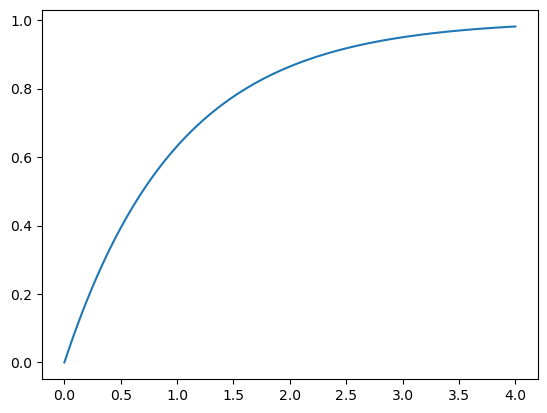

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def plot(x, y, n):
    plt.plot(x,y,'-')
    plt.xlim(0,n)
    plt.ylim(bottom = 0)

def G(u, v, j, k):
    return 2*u*k/(v-u+v*j+u*k+np.sqrt(((v-u+v*j+u*k)**2)-4*(v-u)*u*k))
    
def linear(k0, k1, k2, n):
    S = np.linspace(0,n,100)
    R = (k0 + k1*S)/k2
    plot(S, R, n)

def hyperbolic(k1, k2, RT, n):
    S = np.linspace(0,n,100)
    RP = RT*S/(S + (k2/k1))
    plot(S, RP, n)

def sigmoidal(k1, k2, RT, Km1, Km2, n):
    S = np.linspace(0,n,100)
    RP = RT*G(k1*S, k2, Km1/RT, Km2/RT)
    plot(S, RP, n)
    
#linear(0.01, 1, 5, 3)
#hyperbolic(1, 1, 1, 10)
#sigmoidal(1, 1, 1, 0.05, 0.05, 3)

def dX(X, t, S):
    return S - X

def dR(R, t, S, X):
    return 2*(S - X*R)

def perf_adpt():
    t = np.linspace(0, 4, 100)
    xx = odeint(dX,0,t, args = (1,))
    plt.plot(t, xx)
    
    
perf_adpt()

apm 103.21.127.77_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            3
   Intermediates:            0
   Connections  :            0
   Equations    :            2
   Residuals    :            2
 
 Number of state variables:            800
 Number of total equations: -          800
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains I

C:\Users\Apurv\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Apurv\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


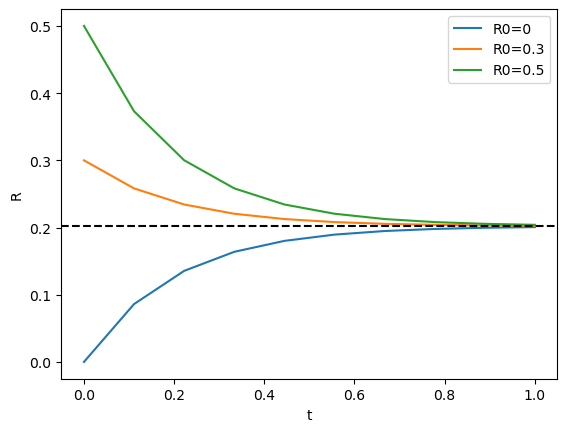

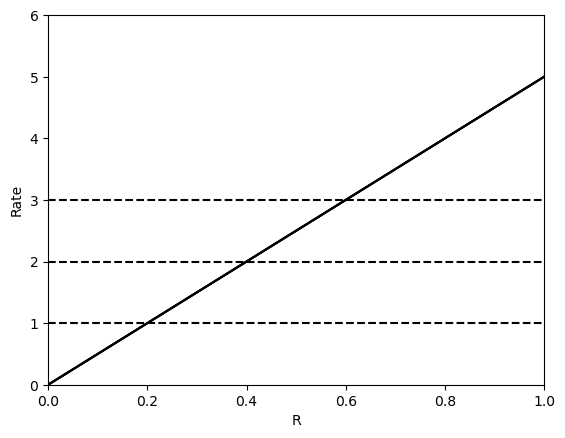

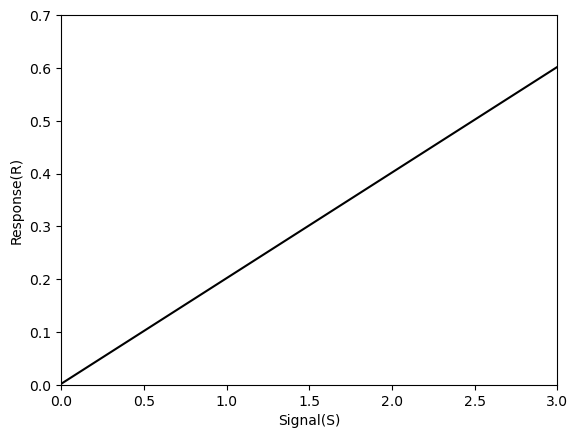

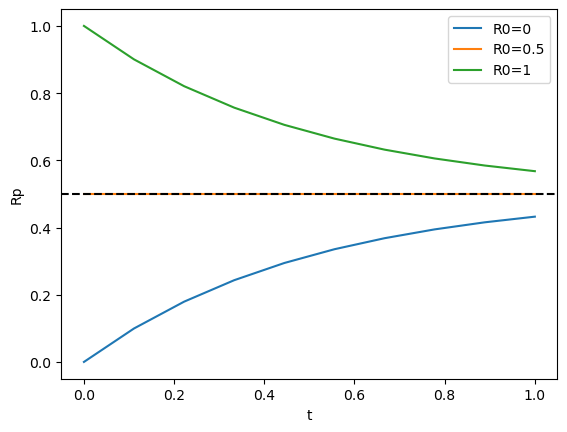

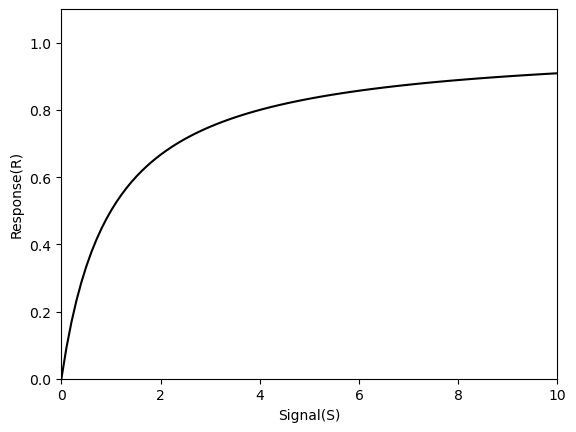

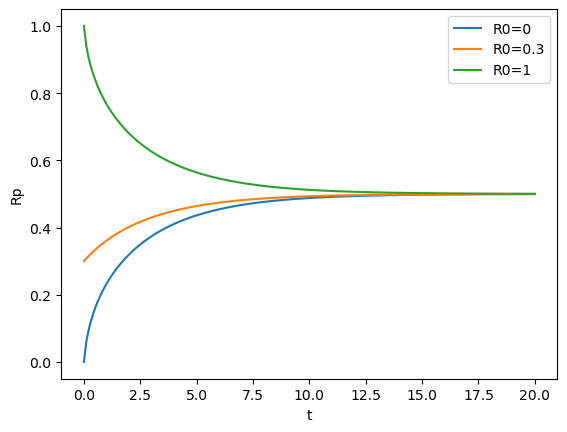

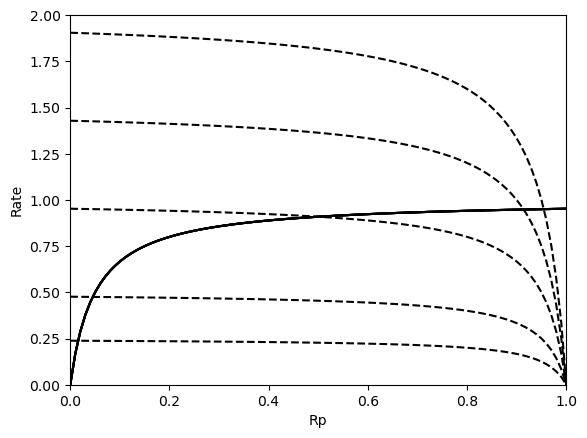

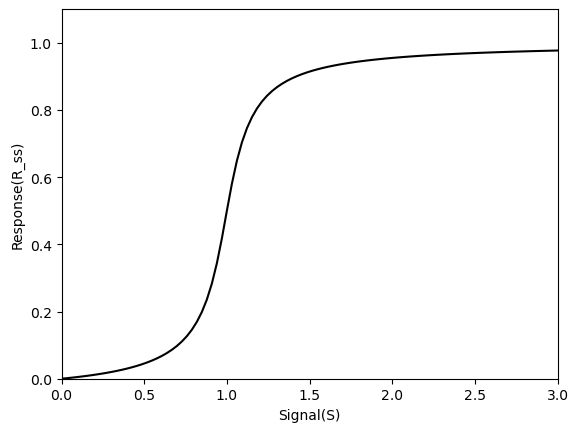

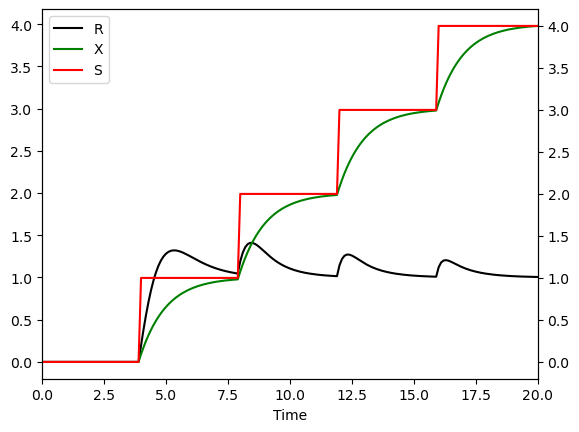

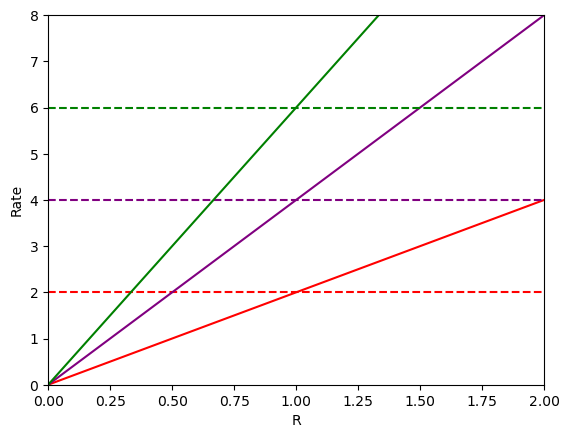

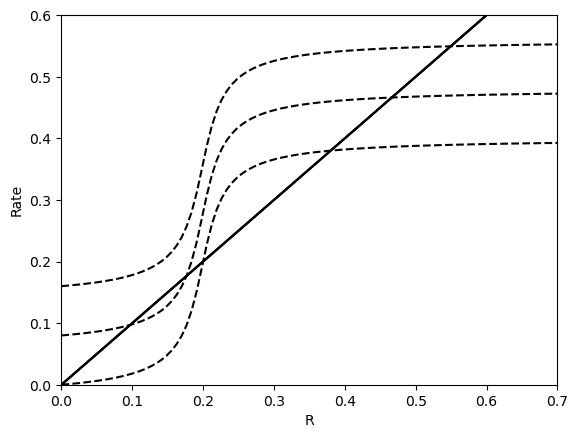

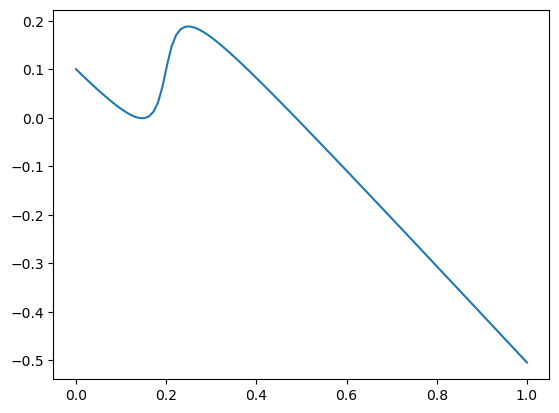

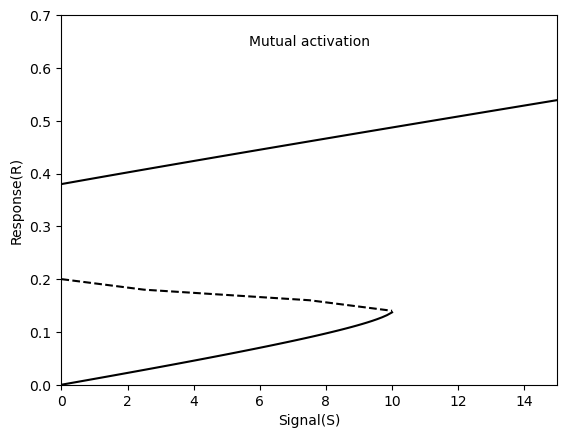

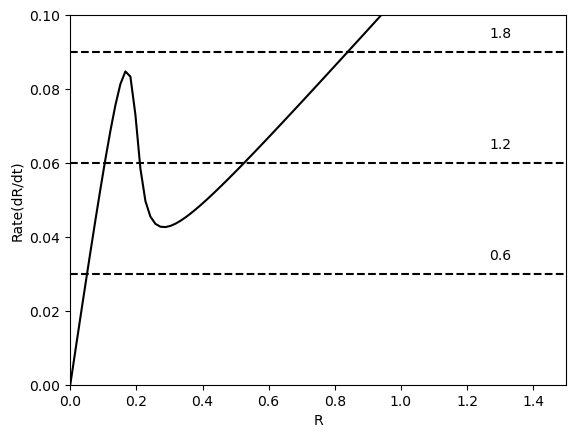

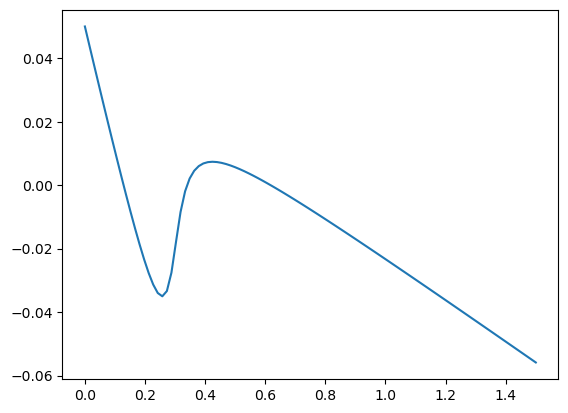

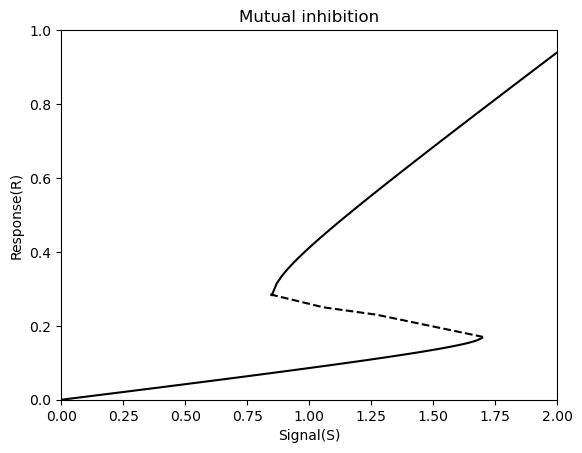

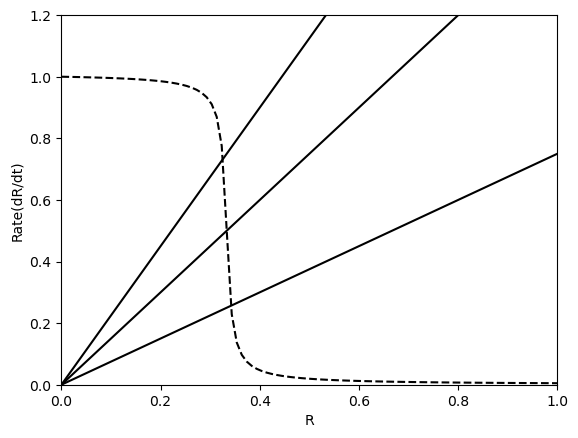

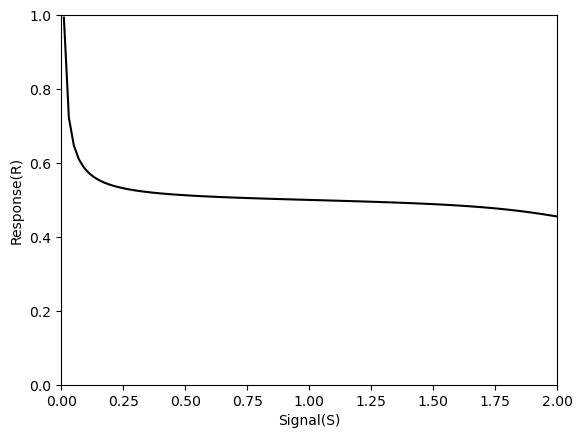

In [3]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from gekko import GEKKO

'''
Figure1A linear signal response
dR/dt = k0 + k1*S - k2*R
'''

def model(R,t,S):
    k0 = 0.01
    k1 = 1
    k2 = 5
    dRdt = k0 + k1*S - k2*R
    return dRdt

R0 = [0,0.3,0.5]
t = np.linspace(0,1,10)
S = 1
result = odeint(model,R0,t,args=(S,))

# solution curve
fig,ax = plt.subplots()
ax.plot(t,result[:,0],label='R0=0')
ax.plot(t,result[:,1],label='R0=0.3')
ax.plot(t,result[:,2],label='R0=0.5')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('R')
ax.axhline(y=0.202,xmin=0,xmax=1,linestyle='--',c='k')
plt.savefig("linear sol.png")

# rate curve
k0 = 0.01
k1 = 1
k2 = 5
fig,ax = plt.subplots()
S_options = [1,2,3]
for S in S_options:
    R = np.linspace(0,1,10)
    removal_rate = k2 * R
    production_rate = [k1 * S] * len(R)
    ax.plot(R,removal_rate,linestyle='-',c='k')
    ax.plot(R,production_rate,linestyle='--',c='k')
ax.set_xlim(0,1)
ax.set_ylim(0,6)
ax.set_xlabel('R')
ax.set_ylabel('Rate')
plt.savefig("linear rate.png")


# signal-response curve
k0 = 0.01
k1 = 1
k2 = 5
S = np.linspace(0,3,7)
R_ss = (k0 + k1*S) / k2
fig,ax = plt.subplots()
ax.plot(S,R_ss,linestyle='-',c='k')
ax.set_xlim(0,3)
ax.set_ylim(0,0.7)
ax.set_xlabel('Signal(S)')
ax.set_ylabel('Response(R)')
plt.savefig("linear signal.png")

'''
Figure1B, hyperbolic response
dRp/dt = k1*S(Rt-Rp) - k2*Rp
'''

def model(y,t,S):
    k1 = 1
    k2 = 1
    Rt = 1
    dydt = k1*S*(Rt-y) - k2*y
    return dydt

S = 1
Rp0 = [0,0.5,1]
t = np.linspace(0,1,10)
result = odeint(model,Rp0,t,args=(S,))


# solution curve
fig,ax = plt.subplots()
ax.plot(t,result[:,0],label='R0=0')
ax.plot(t,result[:,1],label='R0=0.5')
ax.plot(t,result[:,2],label='R0=1')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('Rp')
ax.axhline(y=0.5,xmin=0,xmax=1,linestyle='--',c='k')
plt.savefig("hyperbolic sol.png")




# signal-response curve
k1 = 1
k2 = 1
Rt = 1
S = np.linspace(0,10,100)
Rp_ss = (S * Rt) / (k2/k1 + S)
fig,ax = plt.subplots()
ax.plot(S,Rp_ss,linestyle='-',c='k')
ax.set_xlim(0,10)
ax.set_ylim(0,1.1)
ax.set_xlabel('Signal(S)')
ax.set_ylabel('Response(R)')
plt.savefig("hyperbolic signal.png")

'''
sigmoidal curve
dRp/dt = (k1*S*(Rt-Rp)/(km1+Rt-Rp)) - k2*Rp/(km2+Rp)
'''

def model(Rp,t,S):
    k1 = 1
    k2 = 1
    Rt = 1
    km1 = 0.05
    km2 = 0.05
    dRpdt = (k1*S*(Rt-Rp)/(km1+Rt-Rp)) - k2*Rp/(km2+Rp)
    return dRpdt

S = 1
Rp0 = [0,0.3,1]
t = np.linspace(0,20,200)
result = odeint(model,Rp0,t,args=(S,))

# solution curve
fig,ax = plt.subplots()
ax.plot(t,result[:,0],label='R0=0')
ax.plot(t,result[:,1],label='R0=0.3')
ax.plot(t,result[:,2],label='R0=1')
ax.legend()
ax.set_xlabel('t')
ax.set_ylabel('Rp')
plt.savefig("sig sol.png")


# rate curve
k1 = 1
k2 = 1
Rt = 1
km1 = 0.05
km2 = 0.05
Rp = np.linspace(0,1,100)
fig,ax = plt.subplots()
for S in [0.25,0.5,1,1.5,2]:
    removal_rate = k2*Rp/(km2+Rp)
    production_rate = k1*S*(Rt-Rp)/(km1+Rt-Rp)
    ax.plot(Rp,removal_rate,linestyle='-',c='k')
    ax.plot(Rp,production_rate,linestyle='--',c='k')
ax.set_xlim(0,1)
ax.set_xlabel('Rp')
ax.set_ylim(0,2)
ax.set_ylabel('Rate')
plt.savefig("sig rate.png")

# signal-response curve
S_all = np.linspace(0,3,100)
def equation(Rp,S):
    k1 = 1
    k2 = 1
    Rt = 1
    km1 = 0.05
    km2 = 0.05
    return k1*S*(Rt-Rp)/(km1+Rt-Rp) - k2*Rp/(km2+Rp)

from scipy.optimize import fsolve
store = []
for S in S_all:
    Rp_ss = fsolve(equation,[1],args=(S,))[0]
    store.append(Rp_ss)

fig,ax = plt.subplots()
ax.plot(S_all,store,c='k')
ax.set_xlim(0,3)
ax.set_xlabel('Signal(S)')
ax.set_ylim(0,1.1)
ax.set_ylabel('Response(R_ss)')
plt.savefig("sig signal.png")

'''
Figure1d perfectly adaptation to signal
dR/dt = k1*S - k2*X*R
dX/dt = k3*S - k4*X
'''

# solution curve
from gekko import GEKKO
k1,k2,k3,k4 = 2,2,1,1
m = GEKKO()
m.time = np.linspace(0,20,201)
S = np.array([0] * 40 + [1] * 40 + [2] * 40 + [3] * 40 + [4] * 41)
S_param = m.Param(value=S)
X_var = m.Var(value=0)
R_var = m.Var(value=0)
m.Equation(X_var.dt()==k3*S_param-k4*X_var)
m.Equation(R_var.dt()==k1*S_param-k2*X_var*R_var)
m.options.IMODE = 4
m.solve()

fig,ax1 = plt.subplots()
ax1.plot(m.time,R_var,c='k')
ax1.plot(m.time,X_var,c='g')
ax1.set_xlim(0,20)
ax1.set_xlabel('Time')
ax2 = ax1.twinx()
ax2.plot(m.time,S_param,c='r')
import matplotlib.lines as mlines
ax1.legend(handles=[mlines.Line2D([],[],c=i,linestyle='-') for i in 'kgr'],labels=['R','X','S'])
plt.savefig("peft sol.png")

# rate curve
S_options = [1,2,3]
fig,ax = plt.subplots()
for S in S_options:
    R = np.linspace(0,2,100)
    X_ss = k3*S/k4
    removal_rate = k2 * X_ss * R
    production_rate = [k1*S] * len(R)
    tmp_dict = {1:'r',2:'purple',3:'g'}
    ax.plot(R,removal_rate,c=tmp_dict[S],linestyle='-')
    ax.plot(R,production_rate,c=tmp_dict[S],linestyle='--')
ax.set_xlim(0,2)
ax.set_ylim(0,8)
ax.set_xlabel('R')
ax.set_ylabel('Rate')
plt.savefig("peft rate.png")

'''
Figure1e mutual activation, one-way switch
'''
k0,k1,k2,k3,k4,J3,J4 = 0.4,0.01,1,1,0.2,0.05,0.05
def Goldbeter_Koshland(v1,v2,J1,J2):
    '''
    will return the equalibrium concertration of either phosphorated or unphosphorated form of E,
    v1,J1: incoming
    v2,J2: outcoming
    '''
    B = v2-v1+J1*v2+J2*v1
    equilibrium = 2*v1*J2/(B+np.sqrt(B**2-4*(v2-v1)*v1*J2))
    return equilibrium

def model(R,t,S):
    EP = Goldbeter_Koshland(k3*R,k4,J3,J4)
    dRdt = k0*EP + k1*S - k2*R
    return dRdt

t = np.linspace(0,10,100)
result = odeint(model,y0=1,t=t,args=(0,))

# solution curve, they don't ask me to do that, skip for now

# rate curve
R = np.linspace(0,0.7,100)
S_options = [0,8,16]
fig,ax = plt.subplots()
for S in S_options:
    removal_rate = k2*R
    EP = Goldbeter_Koshland(k3*R,k4,J3,J4)
    production_rate = k0*EP+k1*S
    ax.plot(R,removal_rate,c='k',linestyle='-')
    ax.plot(R,production_rate,c='k',linestyle='--')
ax.set_xlim(0,0.7)
ax.set_xlabel('R')
ax.set_ylim(0,0.6)
ax.set_ylabel('Rate')
plt.savefig("mut_act rate.png")

# signal-response curve
S_options = np.linspace(0,15,100)
def equation(R,S):
    EP = Goldbeter_Koshland(k3*R,k4,J3,J4)
    return k0*EP + k1*S - k2*R

# it's necessary to first check the vector field
fig,ax = plt.subplots()
S = 10
test = [equation(R,S) for R in np.linspace(0,1,100)]
ax.plot(np.linspace(0,1,100),test)
# you can find two stable steady state and an unstable steady state

fig,ax = plt.subplots()
store_uplimb,store_downlimb = [],[]
for S in S_options:
    R_ss_uplimb = fsolve(func=equation,x0=[1],args=(S,))[0]
    R_ss_downlimb = fsolve(func=equation,x0=[0],args=(S,))[0]
    store_uplimb.append(R_ss_uplimb)
    store_downlimb.append(R_ss_downlimb)
ax.plot(S_options,store_uplimb,c='k')
ax.plot(S_options[0:67],store_downlimb[0:67],c='k')
ax.plot(np.linspace(0,10,5),[0.2,0.18,0.17,0.16,0.14],c='k',linestyle='--')
ax.set_xlim(0,15)
ax.set_ylim(0,0.7)
ax.set_xlabel('Signal(S)')
ax.set_ylabel('Response(R)')
ax.text(x=7.5,y=0.65,s='Mutual activation',horizontalalignment='center',verticalalignment='center')
plt.savefig("mut_act signal.png")

'''
Figure1f mutual inhibition
'''
k0=0
k1=0.05
k2=0.1
k2_prime=0.5
k3=1
k4=0.2
J3=0.05
J4=0.05

# rate curve
def Goldbeter_Koshland(v1,v2,J1,J2):
    '''
    will return the equalibrium concertration of either phosphorated or unphosphorated form of E,
    v1,J1: incoming
    v2,J2: outcoming
    '''
    B = v2-v1+J1*v2+J2*v1
    equilibrium = 2*v1*J2/(B+np.sqrt(B**2-4*(v2-v1)*v1*J2))
    return equilibrium
R = np.linspace(0,1.5,100)
S_options = [0.6,1.2,1.8]
ER = Goldbeter_Koshland(k4, k3 * R, J3, J4)
removal_rate = k2 * R + k2_prime * ER * R
fig,ax = plt.subplots()
ax.plot(R,removal_rate,color='k',linestyle='-')
for S in S_options:
    production_rate = [k0+k1*S] * 100
    ax.plot(R,production_rate,color='k',linestyle='--')
ax.set_xlim(0,1.5)
ax.set_ylim(0,0.1)
ax.set_xlabel('R')
ax.set_ylabel('Rate(dR/dt)')
ax.text(x=1.3,y=0.035,s='0.6',horizontalalignment='center',verticalalignment='center')
ax.text(x=1.3,y=0.065,s='1.2',horizontalalignment='center',verticalalignment='center')
ax.text(x=1.3,y=0.095,s='1.8',horizontalalignment='center',verticalalignment='center')
plt.savefig("mut_anhi rate.png")

# SR curve
S_options = np.linspace(0,2,100)
def equation(R,S):
    ER = Goldbeter_Koshland(k4, k3 * R, J3, J4)
    return k0+k1*S-k2*R-k2_prime*ER*R
# peek this equation, traverse starts from 0 or from 1 will end up with two stable solution, one unstable in between
S = 1
R_options = np.linspace(0,1,100)
result = [equation(R,S) for R in R_options]
fig,ax=plt.subplots()
ax.plot(R,result)
# start to plot
fig,ax=plt.subplots()
uplimb,downlimb = [],[]
for S in S_options:
    uplimb.append(fsolve(func=equation,x0=[1],args=(S,))[0])
    downlimb.append(fsolve(func=equation,x0=[0],args=(S,))[0])
ax.plot(S_options[round(100*0.84/2):],uplimb[round(100*0.84/2):],c='k')
ax.plot(S_options[:round(100*1.7/2)],downlimb[:round(100*1.7/2)],c='k')
ax.plot(np.linspace(0.842,1.7,5),[0.285,0.25,0.23,0.20,0.17],c='k',linestyle='--')
ax.set_xlim(0,2)
ax.set_ylim(0,1)
ax.set_xlabel('Signal(S)')
ax.set_ylabel('Response(R)')
ax.set_title('Mutual inhibition')
plt.savefig("tmut_anhi signal.png")


'''
figure1g homestatis, negative feedback
'''
k0=1
k2=1
k3=0.5
k4=1
J3=0.01
J4=0.01

# rate curve
R_options = np.linspace(0,1,100)
S_options = [0.5,1,1.5]
ER = Goldbeter_Koshland(k3,k4*R,J3,J4)  # now k3 is the rate (E -> ER), damn
production_rate = k0*ER
fig,ax=plt.subplots()
ax.plot(R_options,production_rate,c='k',linestyle='--')
for S in S_options:
    removal_rate = k2*S*R
    ax.plot(R_options,removal_rate,c='k',linestyle='-')
ax.set_xlim(0,1)
ax.set_ylim(0,1.2)
ax.set_xlabel('R')
ax.set_ylabel('Rate(dR/dt)')
plt.savefig("home rate.png")

# SR curve
S_options=np.linspace(0.01,2,100)
def equation(R,S):
    ER=Goldbeter_Koshland(k3,k4*R,J3,J4)
    return k0*ER - k2*S*R
# for some reason, the fsolve can not approximate the root of above equation if you set x=1, (asymptotic issue)
points = []
for S in S_options:
    points.append(fsolve(func=equation,x0=[1],args=(S,))[0])
fig,ax = plt.subplots()
ax.plot(S_options,points,c='k')
ax.set_xlim(0,2)
ax.set_ylim(0,1)
ax.set_xlabel('Signal(S)')
ax.set_ylabel('Response(R)')
plt.savefig("home signal.png")



In [4]:
m = GEKKO()
m.time = np.linspace(0,50,100)
#S = m.Param(np.linspace(2,5,100))
S = 4

k0 = 0
k1 = 1
k2 = 0.01
k2_prime = 10
k3 = 0.1
k4 = 0.2
k5 = 0.1
k6 = 0.05
Yt=1
Rt=1
km3=0.01
km4=0.01
km5=0.01
km6=0.01

X = m.Var(value=5.2)
Yp = m.Var(value=0.3)
Rp = m.Var(value=0.01)

m.Equation(X.dt() == k0+k1*S-k2*X+k2_prime*Rp*X)
m.Equation(Yp.dt() == (k3*X*(Yt-Yp))/(km3+Yt-Yp) - (k4*Yp)/(km4+Yp))
m.Equation(Rp.dt() == (k5*Yp*(Rt-Rp))/(km5+Rt-Rp) - (k6*Rp)/(km6+Rp))

m.options.IMODE=4
m.options.MAX_ITER = 600
m.solve(disp=True)

fig,ax1 = plt.subplots()
ax1.plot(m.time,Rp,c='k')
ax1.plot(m.time,X,c='g')
ax1.plot(m.time,Yp,c='r')
ax1.set_xlim(0,20)
ax1.set_xlabel('Time')
#ax2 = ax1.twinx()
#ax2.plot(m.time,S_param,c='r')
import matplotlib.lines as mlines
ax1.legend(handles=[mlines.Line2D([],[],c=i,linestyle='-') for i in 'kgr'],labels=['Rp','X','Yp'])


apm 103.21.127.77_gk_model1 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            3
   Intermediates:            0
   Connections  :            0
   Equations    :            3
   Residuals    :            3
 
 Number of state variables:            594
 Number of total equations: -          594
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Simulation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains I

  92r 0.0000000e+00 5.40e-01 1.05e+04   0.4 1.12e+00   2.7 1.00e+00 1.89e-01f  1
  93r 0.0000000e+00 4.68e-01 8.52e+03   0.4 3.94e-01   3.1 1.00e+00 3.95e-01f  1
  94r 0.0000000e+00 3.66e-01 7.24e+03   0.4 1.01e+00   2.7 9.96e-01 2.16e-01f  1
  95r 0.0000000e+00 3.65e-01 5.83e+03   0.4 3.55e-01   3.1 1.00e+00 4.82e-01f  1
  96r 0.0000000e+00 5.74e-01 5.14e+03   0.4 2.42e+00   2.6 2.31e-01 1.72e-01f  1
  97r 0.0000000e+00 5.82e-01 4.17e+03   0.4 2.86e-01   3.0 1.00e+00 2.51e-01f  1
  98r 0.0000000e+00 5.91e-01 3.62e+03   0.4 5.46e-01   2.6 1.00e+00 2.39e-01f  1
  99r 0.0000000e+00 6.16e-01 3.93e+03   0.4 2.20e-01   3.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 0.0000000e+00 6.38e-01 2.29e+03   0.4 5.05e-01   2.5 1.00e+00 5.45e-01f  1
 101r 0.0000000e+00 6.52e-01 1.17e+03   0.4 1.80e-01   2.9 1.00e+00 5.66e-01f  1
 102r 0.0000000e+00 6.64e-01 1.53e+02   0.4 6.82e-02   3.4 1.00e+00 1.00e+00f  1
 103r 0.0000000e+00 6.71e-01

 230r 0.0000000e+00 1.78e-01 5.85e+02  -4.4 5.29e-01    -  2.00e-01 1.00e+00h  1
 231r 0.0000000e+00 1.78e-01 6.42e+02  -4.4 5.14e+00    -  1.00e+00 2.22e-04f  1
 232r 0.0000000e+00 5.39e-01 2.98e+02  -4.4 3.74e+00    -  1.00e+00 7.64e-01f  1
 233r 0.0000000e+00 1.78e+00 2.37e+02  -4.1 5.82e+00    -  1.00e+00 1.00e+00f  1
 234r 0.0000000e+00 2.80e-01 2.38e+03  -4.2 6.62e-01   0.4 5.02e-01 1.00e+00h  1
 235r 0.0000000e+00 1.85e-01 1.72e+03  -4.6 9.22e-02   2.6 2.51e-01 3.40e-01f  1
 236r 0.0000000e+00 1.17e-01 8.54e+02  -2.7 3.89e-02   3.0 1.00e+00 1.00e+00f  1
 237r 0.0000000e+00 1.14e-01 6.60e+02  -2.7 1.33e-01   2.5 4.44e-01 2.34e-01f  1
 238r 0.0000000e+00 1.10e-01 1.07e+02  -2.7 4.66e-02   3.0 1.00e+00 1.00e+00f  1
 239r 0.0000000e+00 9.99e-02 9.04e+02  -2.7 5.84e-01   2.5 1.97e-01 1.58e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 0.0000000e+00 9.76e-02 1.41e+03  -2.7 3.07e-01   2.9 2.27e-01 1.64e-01f  1
 241r 0.0000000e+00 9.74e-02

Exception:  @error: Solution Not Found


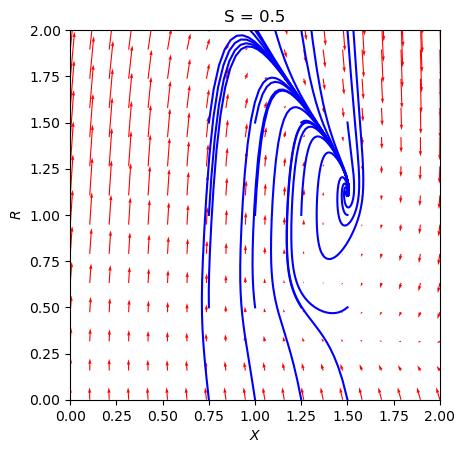

In [49]:
def b2(S):
    def f(Y, t):
        k0,k1,k2,k2prime,k3,k4,k5,k6,J3,J4 = 4,1,1,1,1,1,0.1,0.075,0.3,0.3
        x, r = Y
        dXdt = k5*r - k6*x
        dRdt = k0*Goldbeter_Koshland(k3*r,k4,J3,J4) + k1*S - k2*r - k2prime*x*r
        return [dXdt, dRdt]

    x = np.linspace(0, 2, 20)
    r = np.linspace(0, 3.0, 20)

    X, R = np.meshgrid(x, r)

    t = 0

    u, v = np.zeros(X.shape), np.zeros(R.shape)

    NI, NJ = X.shape

    for i in range(NI):
        for j in range(NJ):
            p = X[i, j]
            q = R[i, j]
            yprime = f([p, q], t)
            u[i,j] = yprime[0]
            v[i,j] = yprime[1]


    Q = plt.quiver(X, R, u, v, color='r', scale = 15)

    from scipy.integrate import odeint

    for y10 in [0.75,1,1.25,1.5]:
        for y20 in [0, 0.5, 1, 1.5, 2, 2.5]:
            tspan = np.linspace(0, 50, 200)
            y0 = [y10, y20]
            ys = odeint(f, y0, tspan)
            plt.plot(ys[:,0], ys[:,1], 'b-') # path
            #plt.plot([ys[0,0]], [ys[0,1]], 'o') # start
            #plt.plot([ys[-1,0]], [ys[-1,1]], 's') # end

    plt.title("S = "+str(S))
    plt.xlabel('$X$')
    plt.ylabel('$R$')
    plt.xlim([0, 2])
    plt.ylim([0, 2])
    ax = plt.gca() #you first need to get the axis handle
    ax.set_aspect(1) 
    plt.savefig("2b S = " + str(S) + ".png")


b2(0.5)




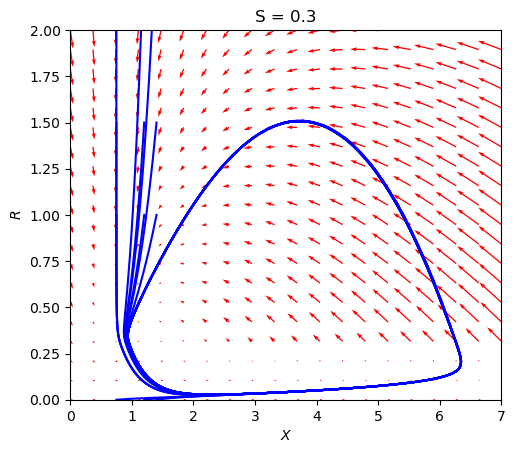

In [42]:
def c2(S):
    def g(Y, t):
        k0prime,k0,k1,k2,k3,k4,J3,J4 = 0.01,0.4,1,1,1,0.3,0.05,0.05
        x, r = Y
        dXdt = k1*S -x*(k0prime+k0*Goldbeter_Koshland(k3*r,k4,J3,J4))
        dRdt = (k0prime+k0*Goldbeter_Koshland(k3*r,k4,J3,J4))*x -k2*r
        return [dXdt, dRdt]

    x = np.linspace(0, 7, 20)
    r = np.linspace(0, 2, 20)

    X, R = np.meshgrid(x, r)

    t = 0

    u, v = np.zeros(X.shape), np.zeros(R.shape)

    NI, NJ = X.shape

    for i in range(NI):
        for j in range(NJ):
            p = X[i, j]
            q = R[i, j]
            yprime = g([p, q], t)
            u[i,j] = yprime[0]
            v[i,j] = yprime[1]


    Q = plt.quiver(X, R, u, v, color='r')

    from scipy.integrate import odeint

    for y10 in [0.75,1.2,1.4]:
        for y20 in [0, 1, 1.5, 2.5]:
            tspan = np.linspace(0, 50, 200)
            y0 = [y10, y20]
            ys = odeint(g, y0, tspan)
            plt.plot(ys[:,0], ys[:,1], 'b-') # path
            #plt.plot([ys[0,0]], [ys[0,1]], 'o') # start
            #plt.plot([ys[-1,0]], [ys[-1,1]], 's') # end

    plt.title("S = "+str(S))
    plt.xlabel('$X$')
    plt.ylabel('$R$')
    plt.xlim([0, 7])
    plt.ylim([0, 2])
    ax = plt.gca() #you first need to get the axis handle
    ax.set_aspect(3) 
    plt.savefig("2c S = " + str(S) + ".png")

c2(0.3)

